In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [2]:
from math import pi 
from qiskit.circuit.library import QFT, DraperQFTAdder, RGQFTMultiplier
from qiskit import execute

In [14]:
def prepare_state(bit_string : str):
    bit_string = bit_string[::-1]
    n = len(bit_string)
    qc = QuantumCircuit(n)
    for i, s in zip(range(n), bit_string):
        if s == '1':
            qc.x(i)
    return qc

In [13]:
# QFT??

### **QFT**

### QFT from Qiskit library

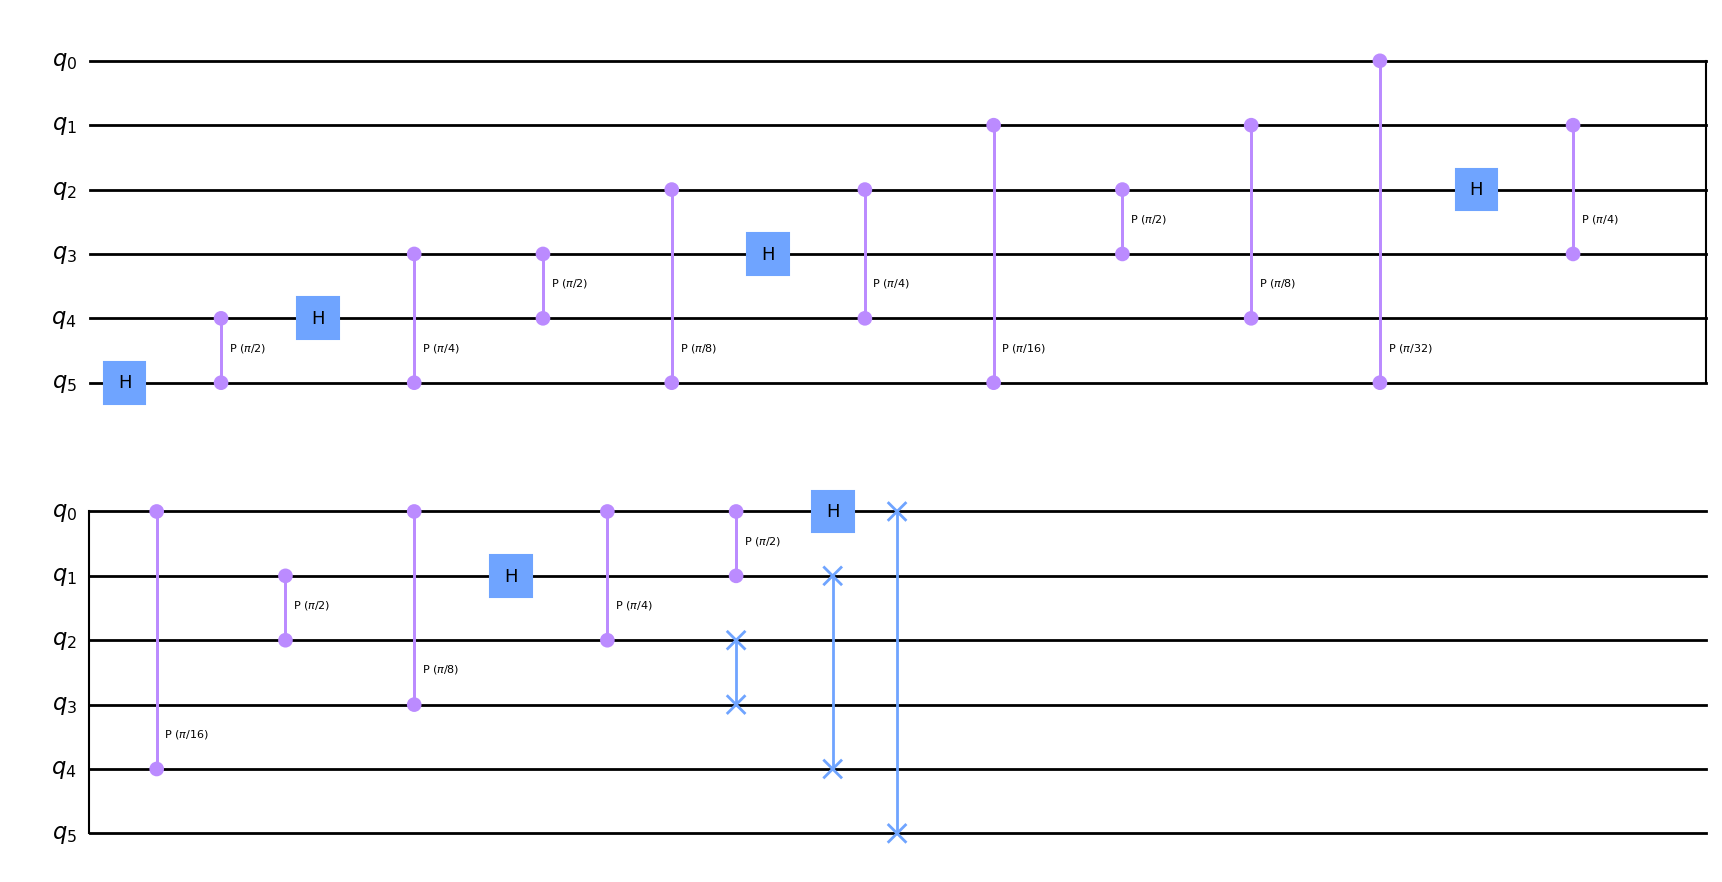

In [38]:
# For example
QFT(6).decompose().draw()

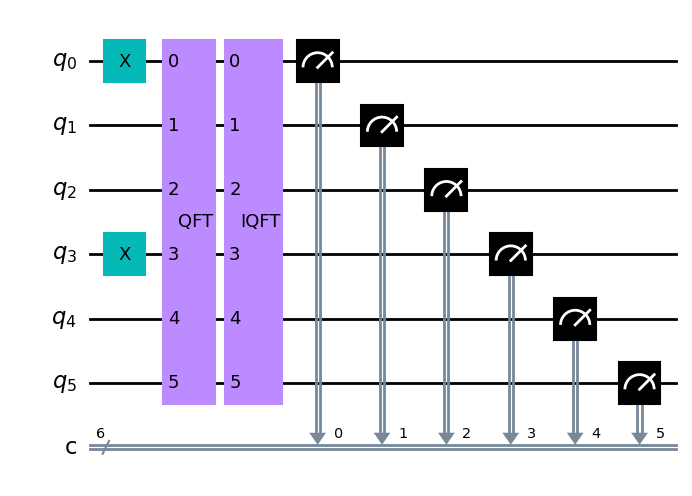

In [24]:
n = 6
q = QuantumCircuit(n,n)
q.x(0)
q.x(3)
q.append(QFT(n, name='QFT'), list(range(n)))
q.append(QFT(n, inverse=True, name='IQFT'), list(range(n)))
q.measure(list(range(n)), list(range(n)))
q.draw()

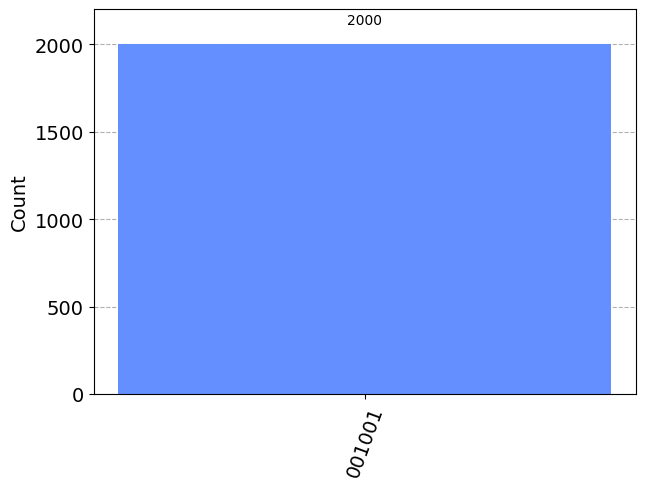

In [25]:
plot_histogram(execute(q, backend=AerSimulator(), shots=2000).result().get_counts())

### QFT from Scratch

In [148]:
def qft_rotations(circuit, n:int):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n:int):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n:int, do_swaps:bool=True):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    if do_swaps:
        swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n:int, do_swaps:bool=True):
    """Does the inverse QFT on the first n qubits in circuit"""
    if do_swaps:
        # First we create a QFT circuit of the correct size:
        qft_circ = qft(QuantumCircuit(n), n)
        # Then we take the inverse of this circuit
        invqft_circ = qft_circ.inverse()
    else:
        qft_circ = qft(QuantumCircuit(n), n, do_swaps=False)
        invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit
    #return circuit.decompose() # .decompose() allows us to see the individual gates

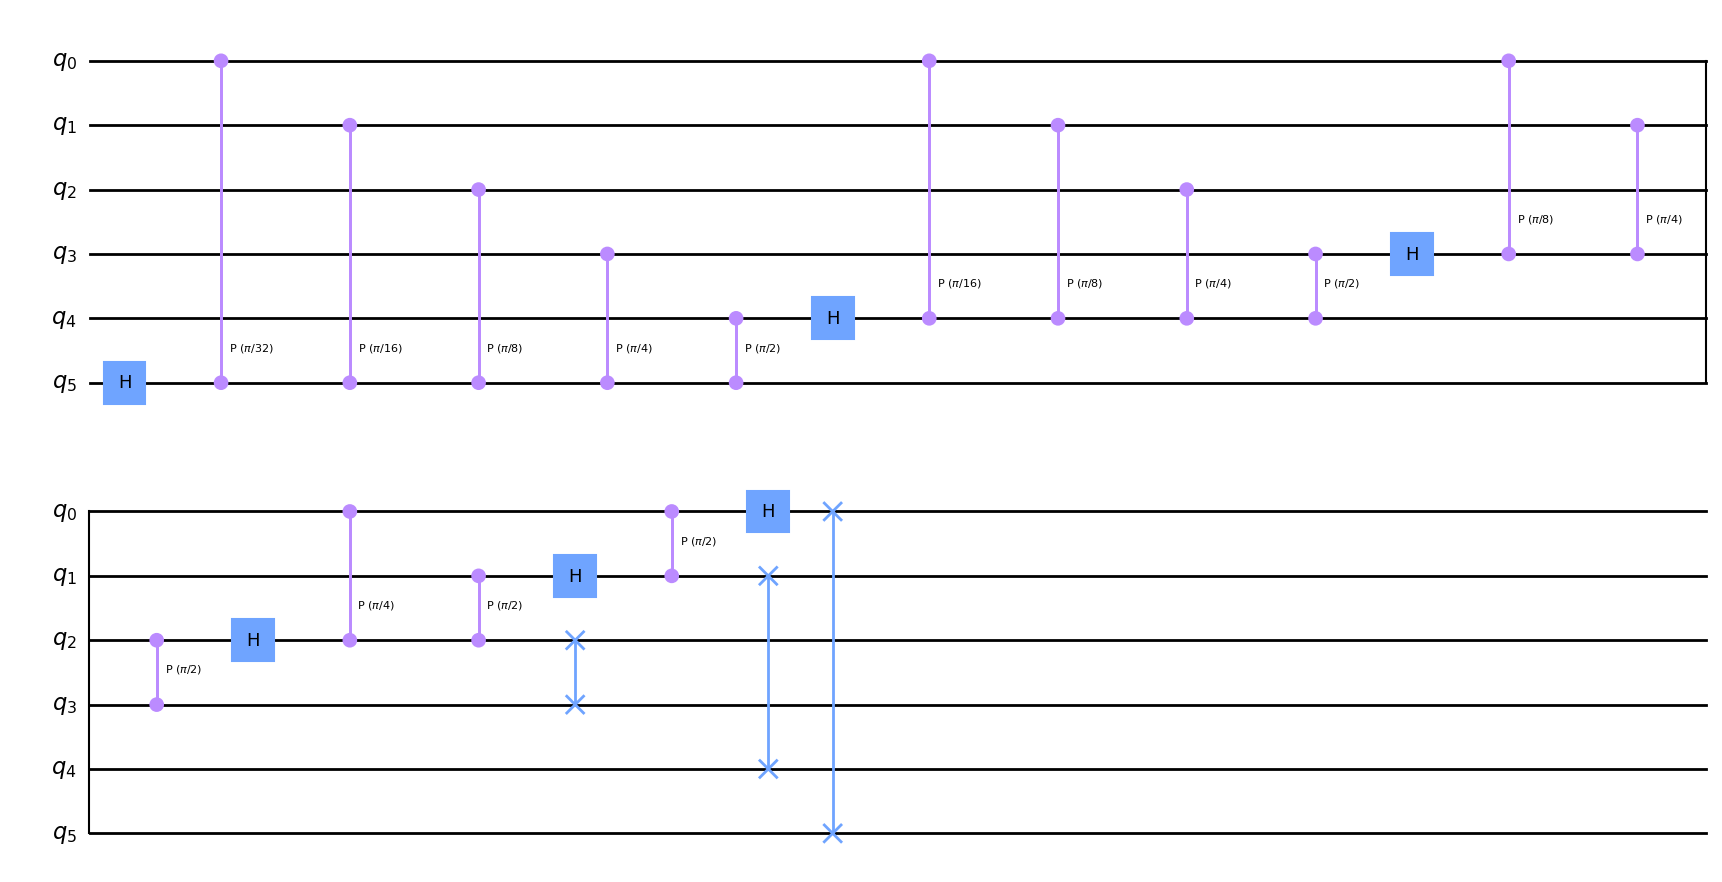

In [39]:
# For example
qft(QuantumCircuit(6), 6).draw()

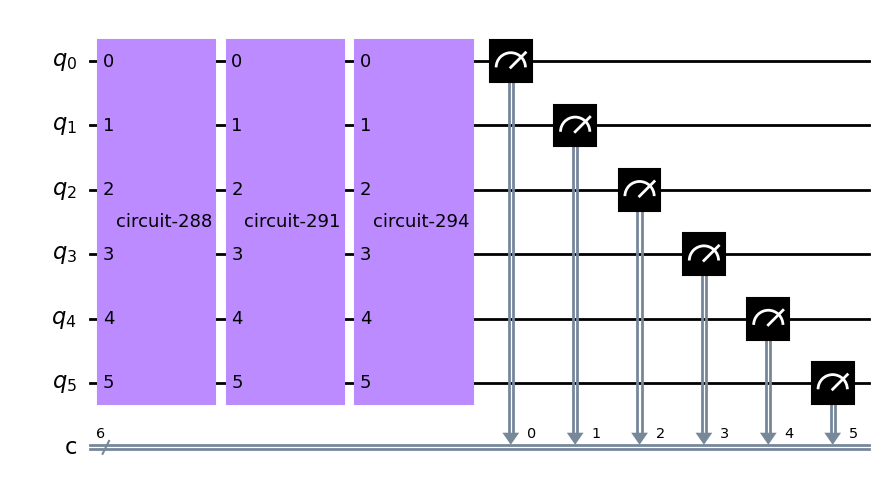

In [35]:
n = 6
qft_circ = QuantumCircuit(n,n)
qft_circ.append(prepare_state('100010'), list(range(n)))
qft_circ.append(qft(QuantumCircuit(n), n, do_swaps=True), list(range(n)))
qft_circ.append(inverse_qft(QuantumCircuit(n), n), list(range(n)))
qft_circ.measure(list(range(n)), list(range(n)))
qft_circ.draw()

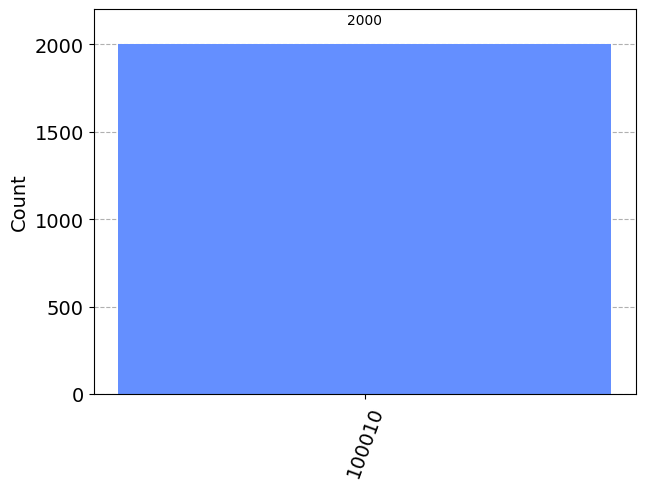

In [36]:
plot_histogram(execute(qft_circ, backend=AerSimulator(), shots=2000).result().get_counts())

### **QFT Adder**

In [40]:
DraperQFTAdder??

Init signature:
DraperQFTAdder(
    num_state_qubits: int,
    kind: str = 'fixed',
    name: str = 'DraperQFTAdder',
) -> None
Source:        
class DraperQFTAdder(Adder):
    r"""A circuit that uses QFT to perform in-place addition on two qubit registers.

    For registers with :math:`n` qubits, the QFT adder can perform addition modulo
    :math:`2^n` (with ``kind="fixed"``) or ordinary addition by adding a carry qubits (with
    ``kind="half"``).

    As an example, a non-fixed_point QFT adder circuit that performs addition on two 2-qubit sized
    registers is as follows:

    .. parsed-literal::

         a_0:   ─────────■──────■────────────────────────■────────────────
                         │      │                        │
         a_1:   ─────────┼──────┼────────■──────■────────┼────────────────
                ┌──────┐ │P(π)  │        │      │        │       ┌───────┐
         b_0:   ┤0     ├─■──────┼────────┼──────┼────────┼───────┤0      ├
                │      │      

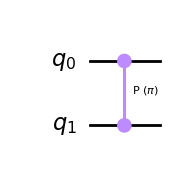

In [75]:
from qiskit.circuit import Parameter

w = QuantumCircuit(2)
# w.x(0)
w.cp(pi, 0,1)
w.draw()

In [76]:
from qiskit import quantum_info as qi

array_to_latex(qi.Operator(w))

<IPython.core.display.Latex object>

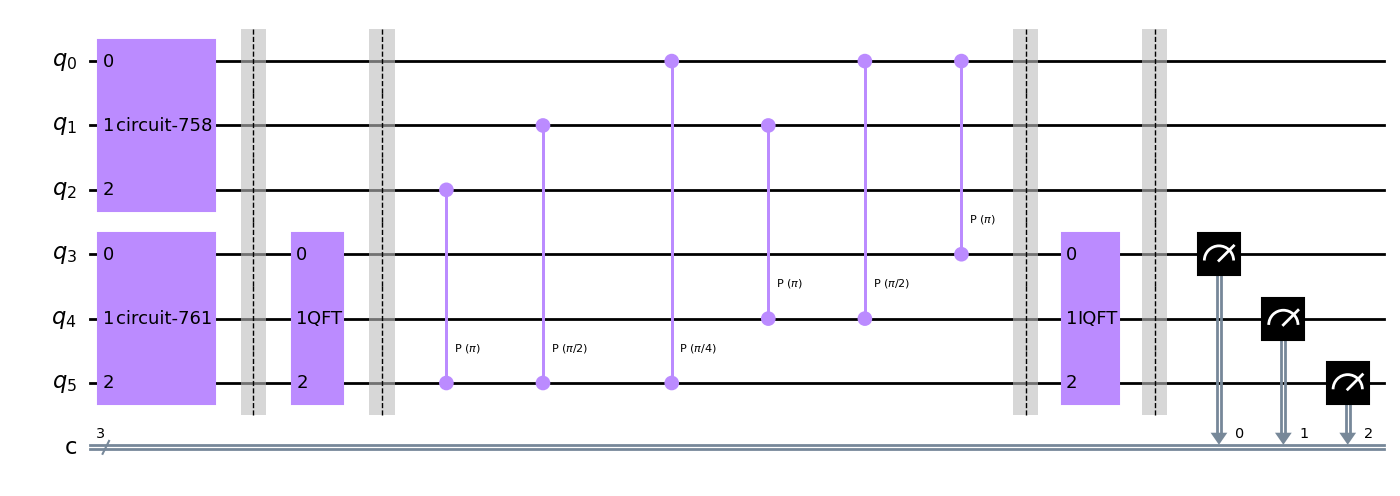

In [121]:
n = 3
qft_circ = QuantumCircuit(2*n,n)

qft_circ.append(prepare_state('001'), list(range(n)))
qft_circ.append(prepare_state('101'), list(range(n,2*n)))

qft_circ.barrier()

# qft_circ.append(qft(QuantumCircuit(n), n, do_swaps=False), list(range(n,2*n)))
qft_circ.append(QFT(n, do_swaps=True), list(range(n,2*n)))

qft_circ.barrier()

for i in range(n):
    for j in range(n-i):
        theta = 2*pi / 2**(j+1)
        qft_circ.cp(theta, control_qubit=n-i-j-1, target_qubit=2*n-i-1)
        
qft_circ.barrier()

# qft_circ.append(inverse_qft(QuantumCircuit(n), n), list(range(n,2*n)))
qft_circ.append(QFT(n, inverse=True, do_swaps=True), list(range(n,2*n)))

qft_circ.barrier()

qft_circ.measure(list(range(n,2*n)), list(range(n)))
qft_circ.draw()

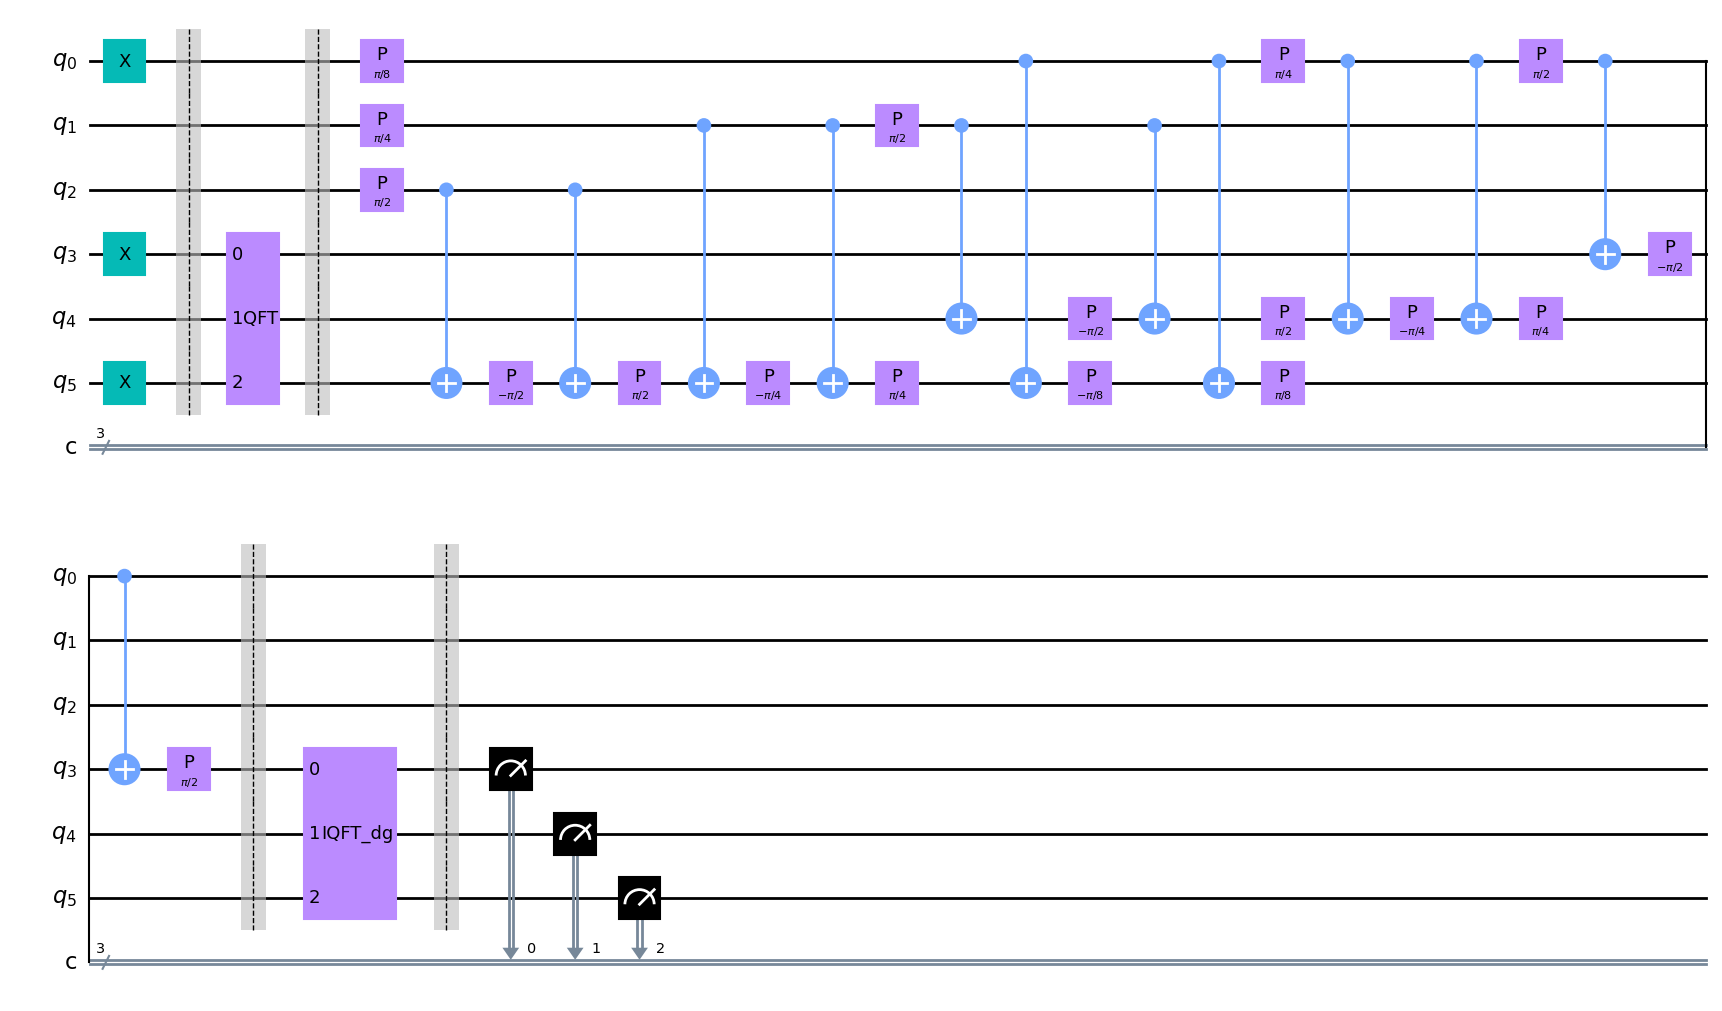

In [122]:
qft_circ.decompose().draw()

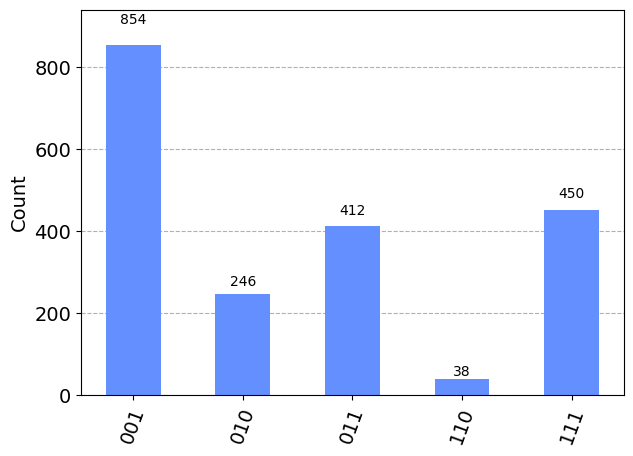

In [123]:
plot_histogram(execute(qft_circ, backend=AerSimulator(), shots=2000).result().get_counts())

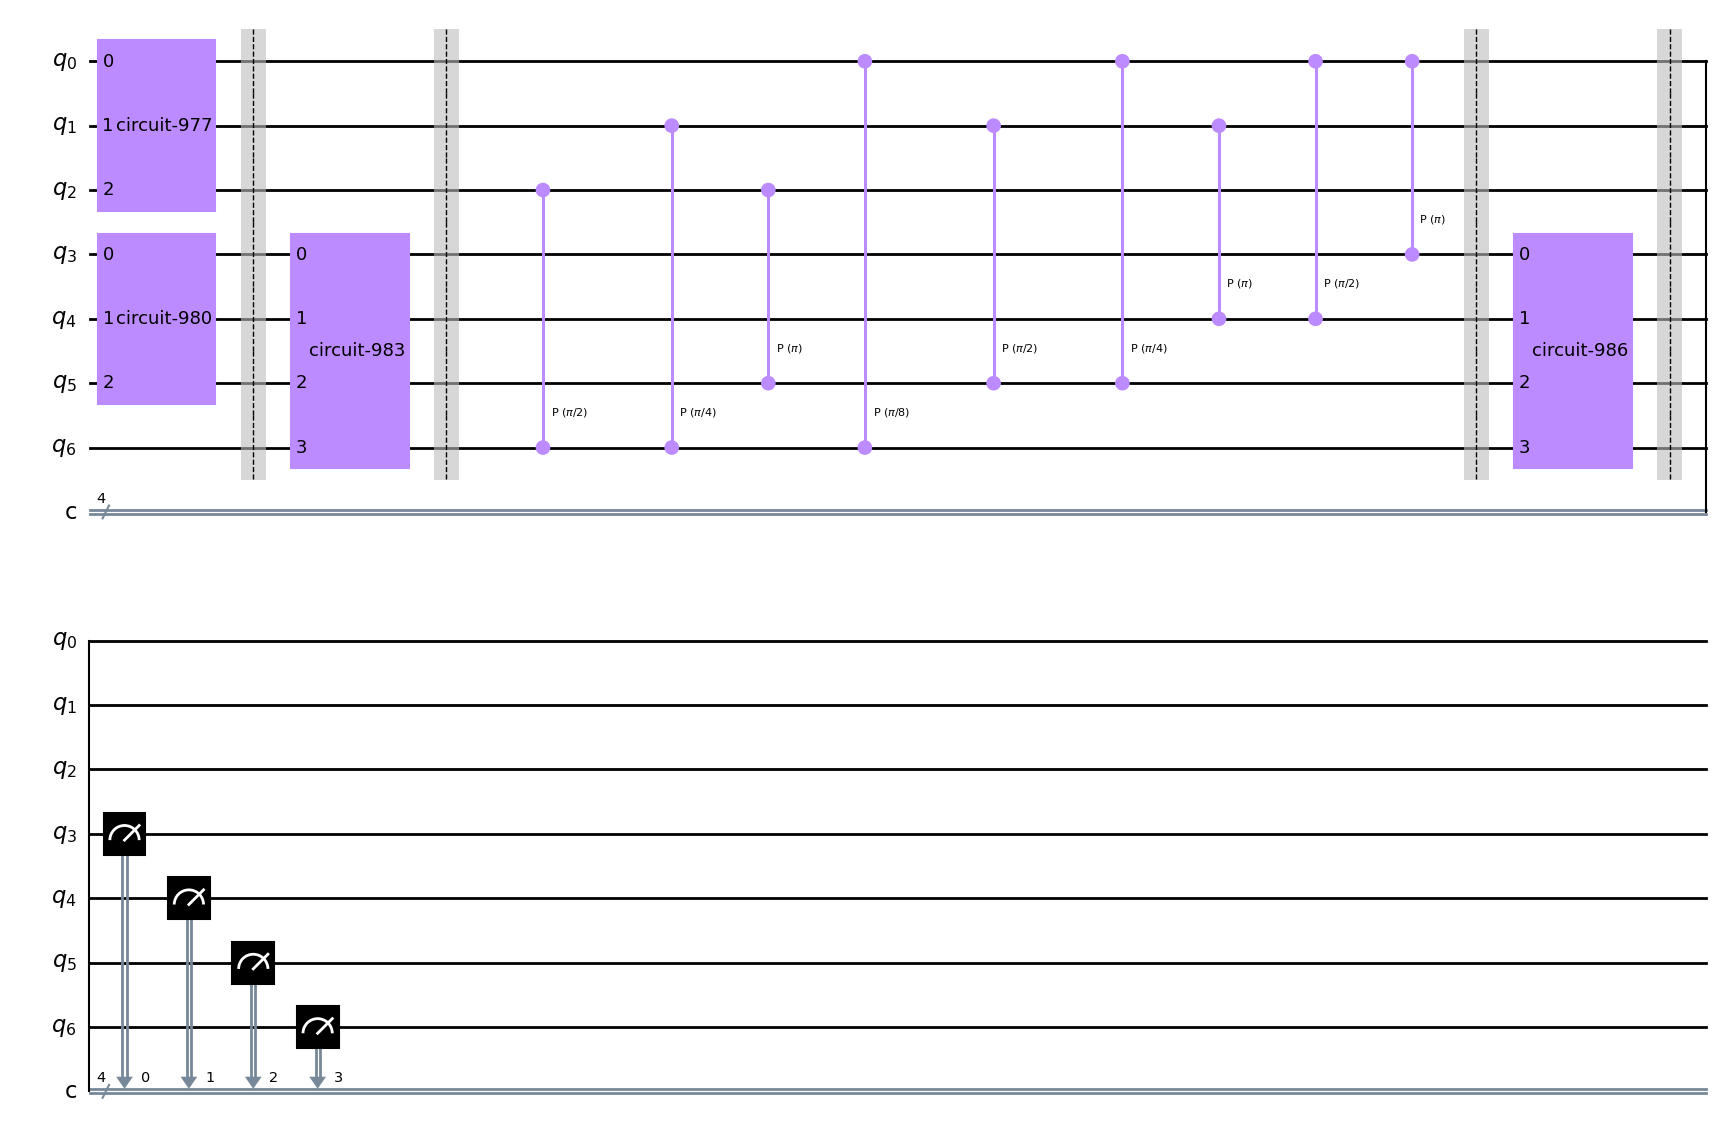

In [155]:
n = 3
qft_circ_1 = QuantumCircuit(2*n+1,n+1)

qft_circ_1.append(prepare_state('101'), list(range(n)))
qft_circ_1.append(prepare_state('101'), list(range(n,2*n)))

# qft_circ_1.x([0,2])

qft_circ_1.barrier()

qft_circ_1.append(qft(QuantumCircuit(n+1), n+1, do_swaps=False), list(range(n,2*n+1)))
# qft_circ_1.append(QFT(n+1, do_swaps=False), list(range(n,2*n+1)))

qft_circ_1.barrier()

for k in range(n):
    theta_1 = 2*pi / 2**(k+2)
    qft_circ_1.cp(theta_1, control_qubit=n-k-1, target_qubit=2*n)

for i in range(n):
    for j in range(n-i):
        theta = 2*pi / 2**(j+1)
        qft_circ_1.cp(theta, control_qubit=n-i-j-1, target_qubit=2*n-i-1)
        
qft_circ_1.barrier()

qft_circ_1.append(inverse_qft(QuantumCircuit(n+1), n+1, do_swaps=False), list(range(n,2*n+1)))
# qft_circ_1.append(QFT(n+1, inverse=True, do_swaps=False), list(range(n,2*n+1)))

qft_circ_1.barrier()

qft_circ_1.measure(list(range(n,2*n+1)), list(range(n+1)))
qft_circ_1.draw()

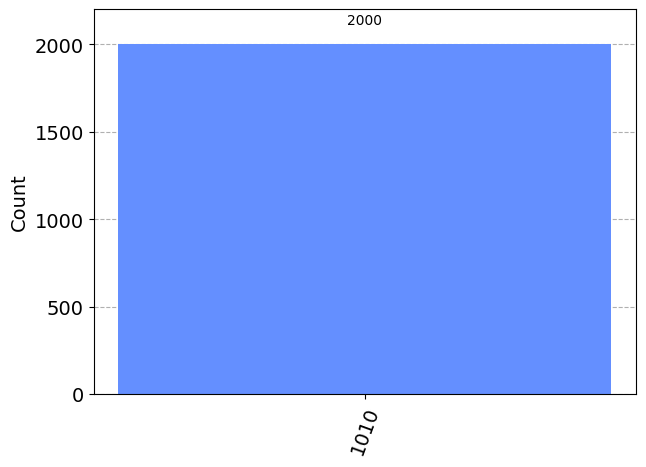

In [156]:
plot_histogram(execute(qft_circ_1, backend=AerSimulator(), shots=2000).result().get_counts())

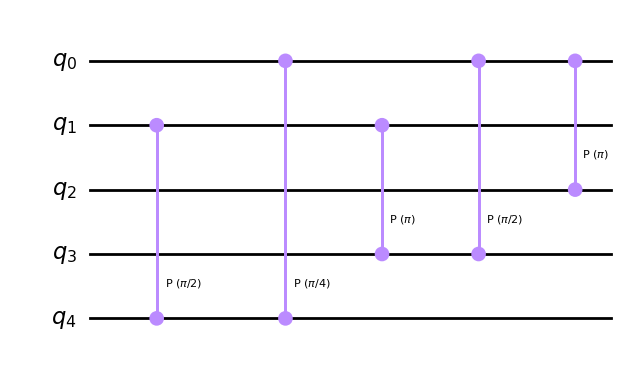

In [136]:
n = 2
test1 = QuantumCircuit(2*n+1)

for k in range(n):
    theta_1 = 2*pi / 2**(k+2)
    test1.cp(theta_1, control_qubit=n-k-1, target_qubit=2*n)

for i in range(n):
    for j in range(n-i):
        theta = 2*pi / 2**(j+1)
        test1.cp(theta, control_qubit=n-i-j-1, target_qubit=2*n-i-1)

        
test1.draw()

In [137]:
array_to_latex(qi.Operator(test1))

<IPython.core.display.Latex object>

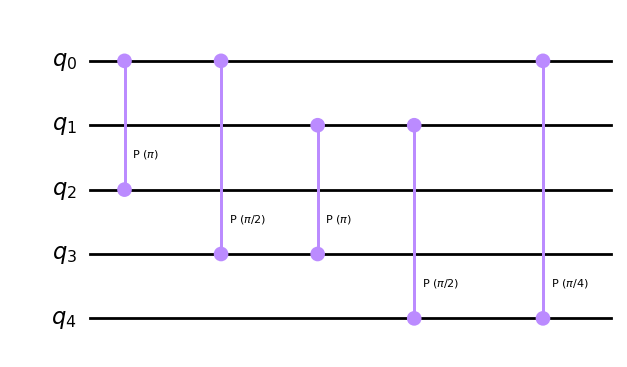

In [140]:
test2 = QuantumCircuit(2*n+1)
test2.cp(pi, control_qubit=0, target_qubit=2)
test2.cp(pi/2, control_qubit=0, target_qubit=3)
test2.cp(pi, control_qubit=1, target_qubit=3)
test2.cp(pi/2, control_qubit=1, target_qubit=4)
test2.cp(pi/4, control_qubit=0, target_qubit=4)
test2.draw()

In [141]:
array_to_latex(qi.Operator(test2))

<IPython.core.display.Latex object>

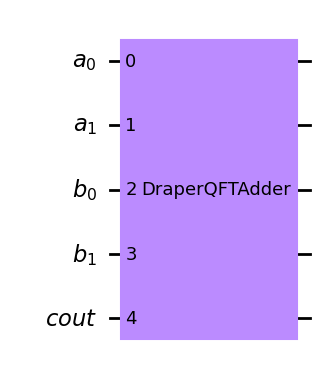

In [128]:
circ = DraperQFTAdder(num_state_qubits=2, kind="half")
circ.draw()

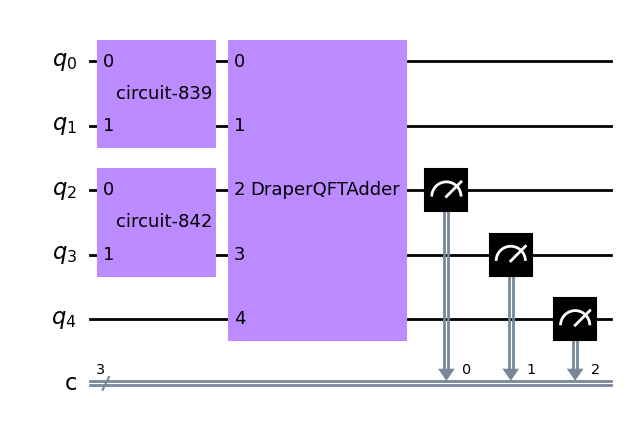

In [132]:
n = 2
qc = QuantumCircuit(2*n+1, n+1)
qc.append(prepare_state('01'), list(range(n)))
qc.append(prepare_state('01'), list(range(n,2*n)))
qc.append(circ, list(range(2*n+1)))
qc.measure(list(range(n,2*n+1)), list(range(n+1)))
qc.draw()

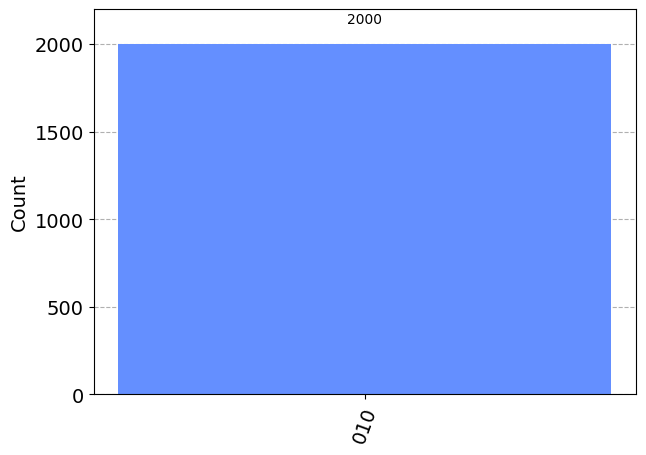

In [134]:
plot_histogram(execute(qc, AerSimulator(), shots=2000).result().get_counts())

### **OUR FINAL QFT_ADDER CIRCUIT THAT WE BUILT FROM SCRATCH**

In [157]:
def equalize_lengths(str1, str2):
    p,q = len(str1), len(str2)
    
    if p>q:
        str2 = '0'*(p-q) + str2
    elif q>p:
        str1 = '0'*(q-p) + str1
        
    return str1, str2

In [158]:
def QFT_ADD(num1:str, num2:str):
    
    p,q = len(num1), len(num2)
    
    if p!=q:
        num1, num2 = equalize_lengths(num1, num2)
    n = len(num1)    
    
    qft_circ_1 = QuantumCircuit(2*n+1,n+1)

    qft_circ_1.append(prepare_state(num1), list(range(n)))
    qft_circ_1.append(prepare_state(num2), list(range(n,2*n)))

    qft_circ_1.barrier()

    qft_circ_1.append(qft(QuantumCircuit(n+1), n+1, do_swaps=False), list(range(n,2*n+1)))

    qft_circ_1.barrier()

    for k in range(n):
        theta_1 = 2*pi / 2**(k+2)
        qft_circ_1.cp(theta_1, control_qubit=n-k-1, target_qubit=2*n)

    for i in range(n):
        for j in range(n-i):
            theta = 2*pi / 2**(j+1)
            qft_circ_1.cp(theta, control_qubit=n-i-j-1, target_qubit=2*n-i-1)

    qft_circ_1.barrier()

    qft_circ_1.append(inverse_qft(QuantumCircuit(n+1), n+1, do_swaps=False), list(range(n,2*n+1)))

    qft_circ_1.barrier()

    qft_circ_1.measure(list(range(n,2*n+1)), list(range(n+1)))
    
    return qft_circ_1

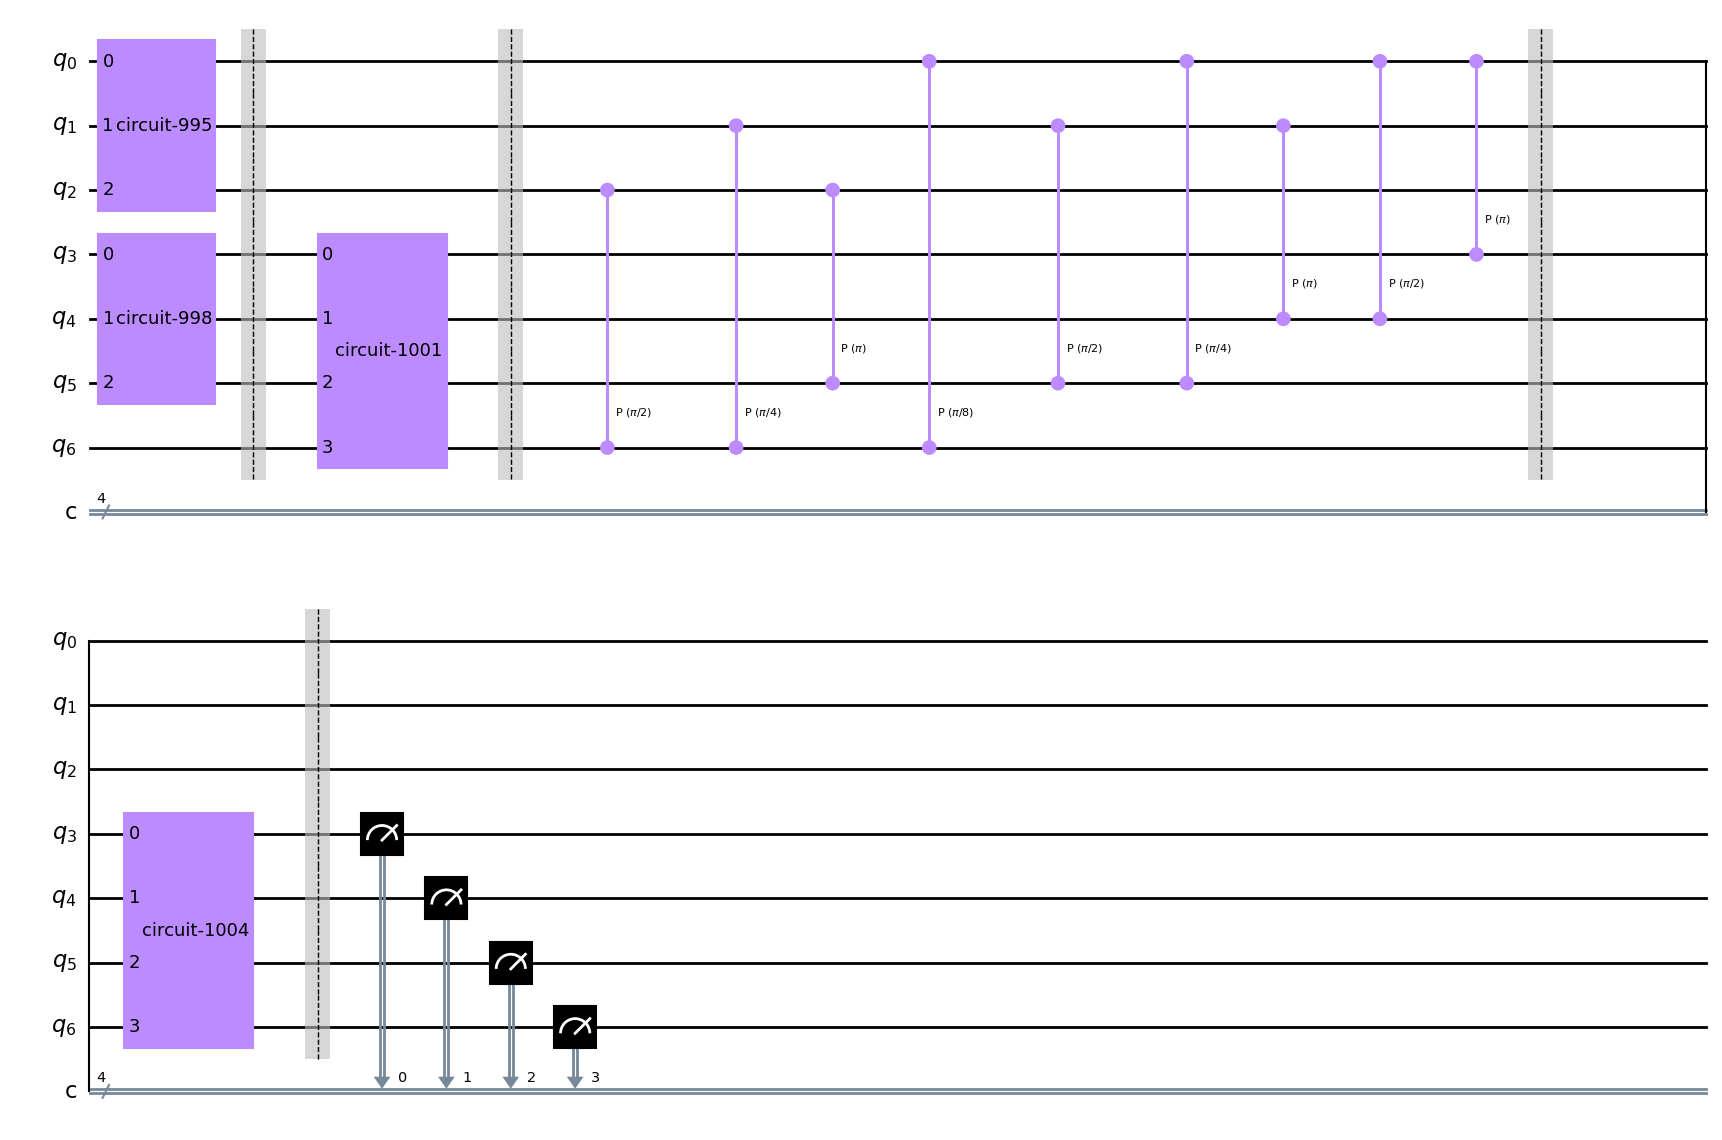

In [159]:
add1 = QFT_ADD('101', '101')
add1.draw()

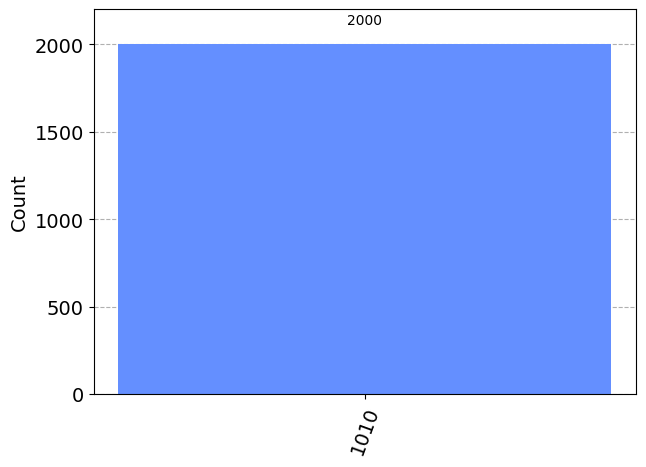

In [160]:
plot_histogram(execute(add1, AerSimulator(), shots=2000).result().get_counts())

Number-1:  3
Number-2:  19


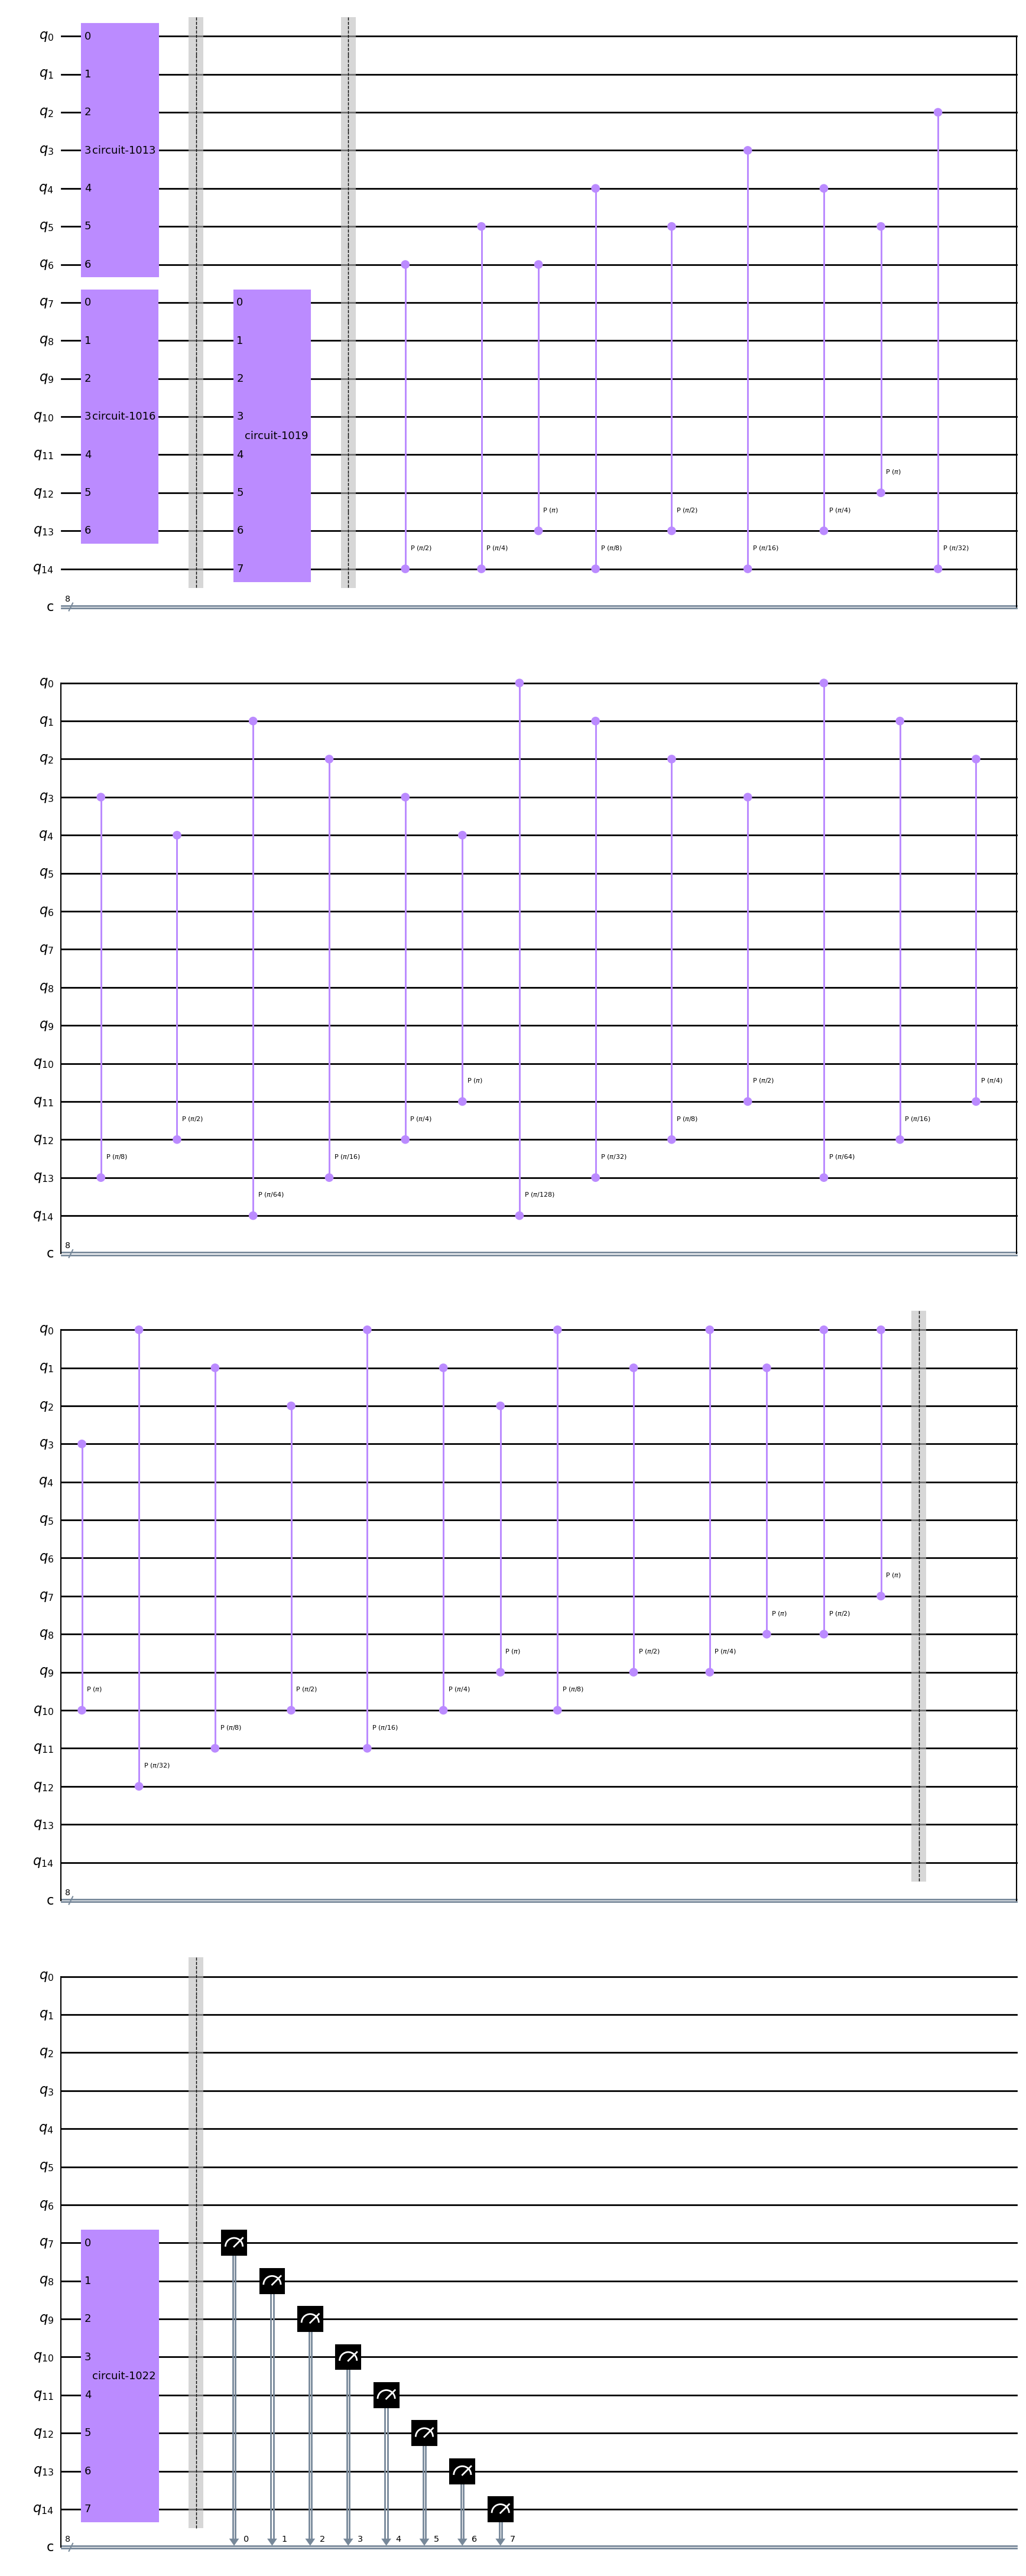

In [161]:
n1 = bin(int(input("Number-1: ")))
n2 = bin(int(input("Number-2: ")))
add2 = QFT_ADD(n1, n2)
add2.draw()

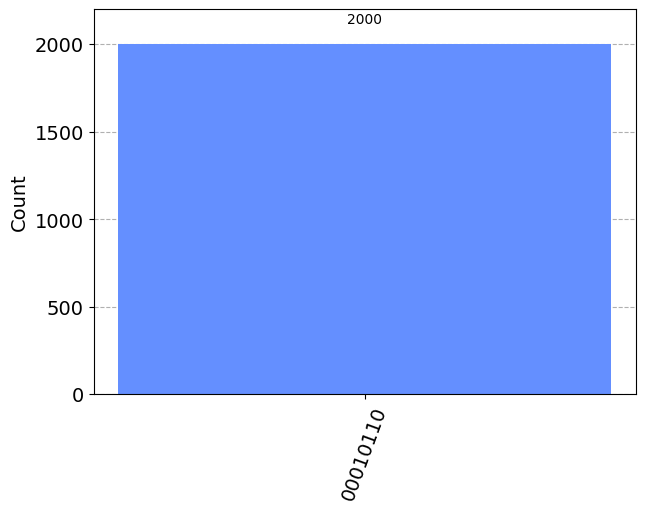

In [162]:
plot_histogram(execute(add2, AerSimulator(), shots=2000).result().get_counts())

Traceback (most recent call last):
  Cell In[163], line 1
    counts
NameError: name 'counts' is not defined

Use %tb to get the full traceback.
